In [2]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

import re

from sklearn import model_selection
from sklearn import linear_model
from sklearn import metrics
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import naive_bayes
from sklearn.feature_extraction.text import CountVectorizer
from nltk.corpus import stopwords

import warnings
warnings.filterwarnings('ignore')

In [3]:
df = pd.read_csv("text.csv")
df.drop(columns=df.columns[0], axis=1, inplace=True)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 416809 entries, 0 to 416808
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    416809 non-null  object
 1   label   416809 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 6.4+ MB


In [5]:
df.head()

,text,label
0,i just feel really helpless and heavy hearted,4
1,ive enjoyed being able to slouch about relax a...,0
2,i gave up my internship with the dmrg and am f...,4
3,i dont know i feel so lost,0
4,i am a kindergarten teacher and i am thoroughl...,4


### Check Label Distribution
The target result seems to be bias, apply kfold for the model

<Axes: xlabel='label', ylabel='count'>

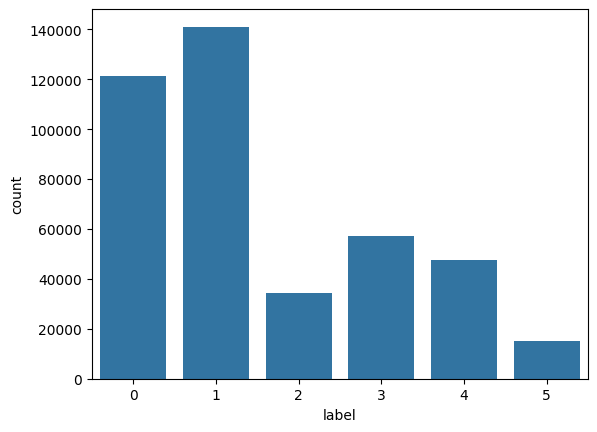

In [9]:
sns.countplot(data = df, x = "label")

<Axes: ylabel='count'>

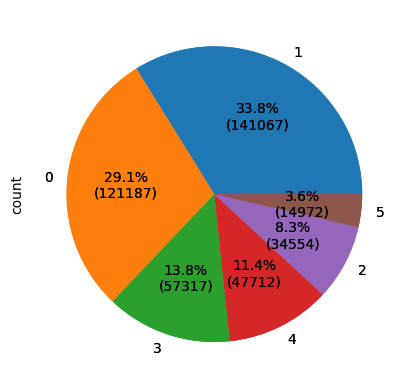

In [10]:
def autopct_format(values):
        def my_format(pct):
            total = sum(values)
            val = int(round(pct*total/100.0))
            return '{:.1f}%\n({v:d})'.format(pct, v=val)
        return my_format

s = df['label'].value_counts()
plt.pie(s,labels = s.index, autopct=autopct_format(s))
s.plot.pie(autopct=autopct_format(s))

### Data Cleaning
1. Removing white space
2. Removing not numbers or letter characters
4. Lowercasing
5. Removing stop words
6. Removing URLs
7. Removing Number
8. Removing specical character

In [6]:
def text_cleaning(text, stopwords):
    # removing space
    text = text.str.replace(r'\s+', ' ', regex = True)
    # removing non number and letter characters
    text = text.apply(lambda x: re.sub(r'[^a-zA-Z\s]', '', x))
    # lowercasing
    text = text.str.lower()
    # removing stop words
    text = text.apply(lambda x: ' '.join([word for word in x.split() if word not in (stopwords)]))
    # removing number
    text = text.str.replace(r'\d+', '', regex = True)
    # removing url
    text = text.str.replace(r'http\S+', '', regex = True)
    # removing special character
    text = text.str.replace(r'[^\w\s]', '', regex = True)
    # removing url
    text = text.str.replace(r'http\S+', '', regex = True)

    return text

In [7]:
stopwords_list = stopwords.words('english')
df['text'] = text_cleaning(df['text'], stopwords_list)

### Create folds

In [29]:
# Create new column "kfold" for df fill with -1
df["kfold"] = -1
# Resample the dataset
df = df.sample(frac = 1).reset_index(drop = True)
# Set y as label
y = df.label.values
# Use StratifiedKFold method as kfold model since the data is bias
kf = model_selection.StratifiedKFold(n_splits=5)

# Apply the folds to the dataset
for f, (t_, v_) in enumerate(kf.split(X = df, y = y)):
    df.loc[v_, "kfold"] = f

In [30]:
df["kfold"].unique()

array([0, 1, 2, 3, 4])

### Data preparation and modeling

#### I. Logistic Regression - TF-IDF

1. Run through each fold for the modeling
2. Use TF-IDF vectorizer with NLTK's word-tokenization function as tokenizer
3. Model -> Logistic Regression

In [31]:
# For each fold from 0, test set should be the selected fold and the rest should be training set
for fold_ in range(5):
    train_df = df[df.kfold!=fold_].reset_index(drop = True)
    test_df = df[df.kfold==fold_].reset_index(drop = True)

    # Use TF-IDF Vectorizer with NLTK's word_tokenize function as tokenizer
    tfidf_vec = TfidfVectorizer(
        tokenizer = word_tokenize,
        token_pattern = None
    )

    # Fit tfidfvec on training text and transform train_df and test_df
    tfidf_vec.fit(train_df.text)

    xtrain = tfidf_vec.transform(train_df.text)
    xtest = tfidf_vec.transform(test_df.text)

    # Initialze logistic regression model and fit on trianing set
    model = linear_model.LogisticRegression(max_iter=1000)
    model.fit(xtrain, train_df.label)

    # Make prediction on test data
    preds = model.predict(xtest)

    # Evaluate the accuracy
    accuracy = metrics.accuracy_score(test_df.label, preds)
    f1 = metrics.f1_score(test_df.label, preds, average='macro')
    
    print(f"Fold: {fold_}")
    print(f"Accuracy = {accuracy}")
    print(f"F1 = {f1}")
    print("---")

Fold: 0
Accuracy = 0.8940764377054293
F1 = 0.8488171637491423
---
Fold: 1
Accuracy = 0.8951440704397687
F1 = 0.8498192105866295
---
Fold: 2
Accuracy = 0.8951200786929296
F1 = 0.8488224738990408
---
Fold: 3
Accuracy = 0.8953240085410619
F1 = 0.8484481938998356
---
Fold: 4
Accuracy = 0.8935593382996845
F1 = 0.8470949558883989
---


#### I. Logistic Regression - CountVectorizer with Bag-of-Words

1. Run through each fold for the modeling
2. Use CountVectorizer with Bag-of-Words function as tokenizer
3. Model -> Logistic Regression

In [33]:
# For each fold from 0, test set should be the selected fold and the rest should be training set
for fold_ in range(5):
    train_df = df[df.kfold!=fold_].reset_index(drop = True)
    test_df = df[df.kfold==fold_].reset_index(drop = True)

    count_vec = CountVectorizer(
        tokenizer = word_tokenize,
        token_pattern = None
    )

    # Fit count_vec on training data reviews
    count_vec.fit(train_df.text)

    xtrain = tfidf_vec.transform(train_df.text)
    xtest = tfidf_vec.transform(test_df.text)

    # Initialze logistic regression model and fit on trianing set
    model = linear_model.LogisticRegression(max_iter=1000)
    model.fit(xtrain, train_df.label)

    # Make prediction on test data
    preds = model.predict(xtest)

    # Evaluate the accuracy
    accuracy = metrics.accuracy_score(test_df.label, preds)
    f1 = metrics.f1_score(test_df.label, preds, average='macro')
    
    print(f"Fold: {fold_}")
    print(f"Accuracy = {accuracy}")
    print(f"F1 = {f1}")
    print("---")

Fold: 0
Accuracy = 0.8943043593004006
F1 = 0.8489206888996147
---
Fold: 1
Accuracy = 0.8940764377054293
F1 = 0.8480346138804125
---
Fold: 2
Accuracy = 0.8949281447182169
F1 = 0.8481334152300507
---
Fold: 3
Accuracy = 0.8946282478827283
F1 = 0.8469993507082539
---
Fold: 4
Accuracy = 0.8935593382996845
F1 = 0.8470949558883989
---


#### II. Naïve Bayes - TF-IDF

1. Run through each fold for the modeling
2. Use TF-IDF vectorizer with NLTK's word-tokenization function as tokenizer
3. Model -> Naïve Bayes

In [34]:
# For each fold from 0, test set should be the selected fold and the rest should be training set
for fold_ in range(5):
    train_df = df[df.kfold!=fold_].reset_index(drop = True)
    test_df = df[df.kfold==fold_].reset_index(drop = True)

    # Use TF-IDF Vectorizer with NLTK's word_tokenize function as tokenizer
    tfidf_vec = TfidfVectorizer(
        tokenizer = word_tokenize,
        token_pattern = None
    )

    # Fit tfidfvec on training text and transform train_df and test_df
    tfidf_vec.fit(train_df.text)

    xtrain = tfidf_vec.transform(train_df.text)
    xtest = tfidf_vec.transform(test_df.text)

    # Initialze logistic regression model and fit on trianing set
    model = naive_bayes.MultinomialNB()
    model.fit(xtrain, train_df.label)

    # Make prediction on test data
    preds = model.predict(xtest)

    # Evaluate the accuracy
    accuracy = metrics.accuracy_score(test_df.label, preds)
    f1 = metrics.f1_score(test_df.label, preds, average='macro')
    
    print(f"Fold: {fold_}")
    print(f"Accuracy = {accuracy}")
    print(f"F1 = {f1}")
    print("---")

Fold: 0
Accuracy = 0.7644250377870013
F1 = 0.5883775930594218
---
Fold: 1
Accuracy = 0.7666562702430364
F1 = 0.5893657031280564
---
Fold: 2
Accuracy = 0.7648928768503634
F1 = 0.590216182430334
---
Fold: 3
Accuracy = 0.7650968066984957
F1 = 0.5858600826836273
---
Fold: 4
Accuracy = 0.7645901560681854
F1 = 0.5843527616697016
---


#### II. Naïve Bayes - CountVectorizer with Bag-of-Words

1. Run through each fold for the modeling
2. Use CountVectorizer with Bag-of-Words function as tokenizer
3. Model -> Naïve Bayes

In [35]:
# For each fold from 0, test set should be the selected fold and the rest should be training set
for fold_ in range(5):
    train_df = df[df.kfold!=fold_].reset_index(drop = True)
    test_df = df[df.kfold==fold_].reset_index(drop = True)

    count_vec = CountVectorizer(
        tokenizer = word_tokenize,
        token_pattern = None
    )

    # Fit count_vec on training data reviews
    count_vec.fit(train_df.text)

    xtrain = tfidf_vec.transform(train_df.text)
    xtest = tfidf_vec.transform(test_df.text)

    # Initialze logistic regression model and fit on trianing set
    model = naive_bayes.MultinomialNB()
    model.fit(xtrain, train_df.label)

    # Make prediction on test data
    preds = model.predict(xtest)

    # Evaluate the accuracy
    accuracy = metrics.accuracy_score(test_df.label, preds)
    f1 = metrics.f1_score(test_df.label, preds, average='macro')
    
    print(f"Fold: {fold_}")
    print(f"Accuracy = {accuracy}")
    print(f"F1 = {f1}")
    print("---")

Fold: 0
Accuracy = 0.7674599937621458
F1 = 0.5938854978334535
---
Fold: 1
Accuracy = 0.7695592716105659
F1 = 0.5948925761205768
---
Fold: 2
Accuracy = 0.767376022648209
F1 = 0.59515421093607
---
Fold: 3
Accuracy = 0.7679038410786689
F1 = 0.5913776049724844
---
Fold: 4
Accuracy = 0.7645901560681854
F1 = 0.5843527616697016
---
